# Climate Indices analysis  for subseaonal forecast - Part II

#### Experiment design:
1. Input variables (X):
   - Surface meterlogy, Surface water temperature, Ice cover (from previous days), climate indices- 1995 onwards
    
2. Output variables (y):
   - Ice data (1995 onwards)
    
3. Period: 
   - 1996 to 2021 (25 years). Note that 1996 includes winter of 1995/1996
   - Training(60%) - 1996 to 2010
   - Validation(20%) - 2011 to 2015
   - Test(20%) - 2016 to 2021
    
4. Predict Interval:
   - Short term foreacast: 5 days and 7 days
   - Subseasonal forecast: 5 weeks (35 days) 
    
5. Preperation of input data:
   - Surface meteorology: daily frequency data - 7 day(168 hours) history data/lag
   - Ice data: daily frequency - 7 day history/lag
   - Water Surface temperature: daily - 7 day history/lag
   - Climate indices: monthly - 3 month history/lag + daily - 7 day lag
   
            Example : If today is 1st Nov at 12 EST then inputs will be...
                  - Surface met: 25th Oct 6 EST to 1st Nov 6 EST
                  - Ice data: 25th Oct to 31st Oct
                  - Water surface temperature: 25th Oct to 31st Oct
                  - Climate indices: July,Aug,Sep
    - Note that the lag periods(7 days/3 months) can be tested in the Hyperparameter tuning phase

### 1. Preperation of Input data

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline   
pd.plotting.register_matplotlib_converters()           
import seaborn as sns  
import altair as alt
from vega_datasets import data
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
meteorology = pd.read_excel("C:/Users/santh/MIDAS/Final_data/meteorlogy_daily.xlsx")
surface_temp = pd.read_csv("C:/Users/santh/MIDAS/Final_data/Surface_Temperature_Without_Remove.csv", usecols=['Date', 'Sup.', 'Huron'], 
                           dtype= {'Sup.':float, 'Huron':float})
ice_data = pd.read_excel("C:/Users/santh/MIDAS/Final_data/ice_data_without_remove.xlsx")
climate_ind_m = pd.read_csv("C:/Users/santh/MIDAS/Final_data/Climate_indices.csv")

In [4]:
meteorology.head()

date    u-wind    v-wind   pressure  humidity  temperature
0 1995-01-01  2.381250 -0.628125  98903.125    30.375   270.178146
1 1995-01-02  4.033125 -1.283125  98336.875    25.500   267.714500
2 1995-01-03  5.938750  0.482500  98652.500    17.125   265.636627
3 1995-01-04  3.722500 -1.425625  99073.125     7.375   259.524513
4 1995-01-05  7.392500  2.583125  98769.375    16.625   264.535141

In [5]:
meteorology.dtypes

date           datetime64[ns]
u-wind                float64
v-wind                float64
pressure              float64
humidity              float64
temperature           float64
dtype: object

In [6]:
meteorology = meteorology.set_index('date')
meteorology.head()

u-wind    v-wind   pressure  humidity  temperature
date                                                            
1995-01-01  2.381250 -0.628125  98903.125    30.375   270.178146
1995-01-02  4.033125 -1.283125  98336.875    25.500   267.714500
1995-01-03  5.938750  0.482500  98652.500    17.125   265.636627
1995-01-04  3.722500 -1.425625  99073.125     7.375   259.524513
1995-01-05  7.392500  2.583125  98769.375    16.625   264.535141

In [7]:
look_back = 4 ############## This will create only 3 lags for all features since the training data contains only 5844 records.

In [8]:
lags = range(1, look_back)

meteorology = meteorology.assign(**{
    f'{col}{lag}': meteorology[col].shift(lag)
    for lag in lags
    for col in meteorology
})

meteorology.head(10)

u-wind    v-wind    pressure  humidity  temperature   u-wind1  \
date                                                                          
1995-01-01  2.381250 -0.628125   98903.125    30.375   270.178146       NaN   
1995-01-02  4.033125 -1.283125   98336.875    25.500   267.714500  2.381250   
1995-01-03  5.938750  0.482500   98652.500    17.125   265.636627  4.033125   
1995-01-04  3.722500 -1.425625   99073.125     7.375   259.524513  5.938750   
1995-01-05  7.392500  2.583125   98769.375    16.625   264.535141  3.722500   
1995-01-06  5.763750  2.210625   97803.125    36.500   269.011017  7.392500   
1995-01-07  0.098125 -3.118125   98220.000     8.000   262.210144  5.763750   
1995-01-08  3.726875  2.000625   98293.750    11.625   264.712128  0.098125   
1995-01-09  4.055000 -0.819375   99311.875     8.125   262.844383  3.726875   
1995-01-10 -2.220625 -1.595000  100214.375    14.500   258.141140  4.055000   

             v-wind1  pressure1  humidity1  temperature1   u-wind2   v-wind2  \
date                                                                           
1995-01-01       NaN        NaN        NaN           NaN       NaN       NaN   
1995-01-02 -0.628125  98903.125     30.375    270.178146       NaN       NaN   
1995-01-03 -1.283125  98336.875     25.500    267.714500  2.381250 -0.628125   
1995-01-04  0.482500  98652.500     17.125    265.636627  4.033125 -1.283125   
1995-01-05 -1.425625  99073.125      7.375    259.524513  5.938750  0.482500   
1995-01-06  2.583125  98769.375     16.625    264.535141  3.722500 -1.425625   
1995-01-07  2.210625  97803.125     36.500    269.011017  7.392500  2.583125   
1995-01-08 -3.118125  98220.000      8.000    262.210144  5.763750  2.210625   
1995-01-09  2.000625  98293.750     11.625    264.712128  0.098125 -3.118125   
1995-01-10 -0.819375  99311.875      8.125    262.844383  3.726875  2.000625   

            pressure2  humidity2  temperature2   u-wind3   v-wind3  pressure3  \
date                                                                            
1995-01-01        NaN        NaN           NaN       NaN       NaN        NaN   
1995-01-02        NaN        NaN           NaN       NaN       NaN        NaN   
1995-01-03  98903.125     30.375    270.178146       NaN       NaN        NaN   
1995-01-04  98336.875     25.500    267.714500  2.381250 -0.628125  98903.125   
1995-01-05  98652.500     17.125    265.636627  4.033125 -1.283125  98336.875   
1995-01-06  99073.125      7.375    259.524513  5.938750  0.482500  98652.500   
1995-01-07  98769.375     16.625    264.535141  3.722500 -1.425625  99073.125   
1995-01-08  97803.125     36.500    269.011017  7.392500  2.583125  98769.375   
1995-01-09  98220.000      8.000    262.210144  5.763750  2.210625  97803.125   
1995-01-10  98293.750     11.625    264.712128  0.098125 -3.118125  98220.000   

            humidity3  temperature3  
date                                 
1995-01-01        NaN           NaN  
1995-01-02        NaN           NaN  
1995-01-03        NaN           NaN  
1995-01-04     30.375    270.178146  
1995-01-05     25.500    267.714500  
1995-01-06     17.125    265.636627  
1995-01-07      7.375    259.524513  
1995-01-08     16.625    264.535141  
1995-01-09     36.500    269.011017  
1995-01-10      8.000    262.210144

In [9]:
surface_temp.head()

Date  Sup.  Huron
0  1995/1/1 0:00  3.29   4.50
1  1995/1/2 0:00  3.28   4.45
2  1995/1/3 0:00  3.27   4.39
3  1995/1/4 0:00  3.27   4.33
4  1995/1/5 0:00  3.22   4.18

In [10]:
surface_temp.dtypes

Date      object
Sup.     float64
Huron    float64
dtype: object

In [11]:
surface_temp['Date'] = pd.to_datetime(surface_temp['Date'], errors = 'coerce')
surface_temp.head()

Date  Sup.  Huron
0 1995-01-01  3.29   4.50
1 1995-01-02  3.28   4.45
2 1995-01-03  3.27   4.39
3 1995-01-04  3.27   4.33
4 1995-01-05  3.22   4.18

In [12]:
surface_temp = surface_temp.set_index('Date')
surface_temp.head()

Sup.  Huron
Date                   
1995-01-01  3.29   4.50
1995-01-02  3.28   4.45
1995-01-03  3.27   4.39
1995-01-04  3.27   4.33
1995-01-05  3.22   4.18

In [13]:
lags = range(1, look_back)

surface_temp = surface_temp.assign(**{
    f'{col}{lag}': surface_temp[col].shift(lag)
    for lag in lags
    for col in surface_temp
})

surface_temp.head(10)

Sup.  Huron  Sup.1  Huron1  Sup.2  Huron2  Sup.3  Huron3
Date                                                                
1995-01-01  3.29   4.50    NaN     NaN    NaN     NaN    NaN     NaN
1995-01-02  3.28   4.45   3.29    4.50    NaN     NaN    NaN     NaN
1995-01-03  3.27   4.39   3.28    4.45   3.29    4.50    NaN     NaN
1995-01-04  3.27   4.33   3.27    4.39   3.28    4.45   3.29    4.50
1995-01-05  3.22   4.18   3.27    4.33   3.27    4.39   3.28    4.45
1995-01-06  3.19   4.06   3.22    4.18   3.27    4.33   3.27    4.39
1995-01-07  3.14   3.90   3.19    4.06   3.22    4.18   3.27    4.33
1995-01-08  3.10   3.75   3.14    3.90   3.19    4.06   3.22    4.18
1995-01-09  3.02   3.59   3.10    3.75   3.14    3.90   3.19    4.06
1995-01-10  2.95   3.25   3.02    3.59   3.10    3.75   3.14    3.90

In [14]:
climate_ind_m.head()

dateTime   NAO   PNA  EPNP  SOI
0  1995-01-01  0.93  0.66  1.03 -0.4
1  1995-02-01  1.14  0.73  0.05 -0.1
2  1995-03-01  1.25  0.33  0.61  0.8
3  1995-04-01 -0.85  0.29  1.13 -0.7
4  1995-05-01 -1.49  0.01  0.72 -0.4

In [15]:
climate_ind_m.dtypes

dateTime     object
NAO         float64
PNA         float64
EPNP        float64
SOI         float64
dtype: object

Observation - Climate indices data is of monthly frequency whereas the rest of the indices are of daily frequency. Hence, we need to convert the Climate indices data to daily frequency inorder to create the consolidated input file.

In [16]:
#Inorder to Upsample the Climate indices data, the dateTime feature has to be an index and has to be a datetime object. 
climate_ind_m['dateTime'] = pd.to_datetime(climate_ind_m['dateTime'], errors='coerce')
climate_ind_m.set_index('dateTime', inplace=True)
climate_ind_m.head()

NAO   PNA  EPNP  SOI
dateTime                         
1995-01-01  0.93  0.66  1.03 -0.4
1995-02-01  1.14  0.73  0.05 -0.1
1995-03-01  1.25  0.33  0.61  0.8
1995-04-01 -0.85  0.29  1.13 -0.7
1995-05-01 -1.49  0.01  0.72 -0.4

In [17]:
#Resample at daily frequnecy, use the start value(in a month) to forward fill for the rest of the days in the month
climate_ind_d = climate_ind_m.resample('D', convention='start').ffill()
climate_ind_d.value_counts()

NAO    PNA    EPNP   SOI 
-3.18   0.76   0.23  -1.1    31
 0.61   0.69  -0.03   2.5    31
 0.19  -0.40  -0.58   0.9    31
       -0.05  -0.32   0.0    31
 0.20   0.41  -0.24   1.0    31
                             ..
 0.29  -0.12  -1.12   1.0    28
 0.45  -0.16   0.26   1.7    28
 0.70  -1.58  -0.12   2.7    28
 1.10   0.14  -0.89   1.1    28
 0.00   0.06  -1.28   1.4     1
Length: 319, dtype: int64

Observation - The climate indices been converted to daily level

In [18]:
#climate_ind_d.reset_index(inplace=True)
climate_ind_d.head()

NAO   PNA  EPNP  SOI
dateTime                         
1995-01-01  0.93  0.66  1.03 -0.4
1995-01-02  0.93  0.66  1.03 -0.4
1995-01-03  0.93  0.66  1.03 -0.4
1995-01-04  0.93  0.66  1.03 -0.4
1995-01-05  0.93  0.66  1.03 -0.4

In [19]:
lags = range(1, look_back)

climate_ind_d = climate_ind_d.assign(**{
    f'{col}{lag}': climate_ind_d[col].shift(lag)
    for lag in lags
    for col in climate_ind_d
})

climate_ind_d.head(10)

NAO   PNA  EPNP  SOI  NAO1  PNA1  EPNP1  SOI1  NAO2  PNA2  EPNP2  \
dateTime                                                                        
1995-01-01  0.93  0.66  1.03 -0.4   NaN   NaN    NaN   NaN   NaN   NaN    NaN   
1995-01-02  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4   NaN   NaN    NaN   
1995-01-03  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4  0.93  0.66   1.03   
1995-01-04  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4  0.93  0.66   1.03   
1995-01-05  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4  0.93  0.66   1.03   
1995-01-06  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4  0.93  0.66   1.03   
1995-01-07  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4  0.93  0.66   1.03   
1995-01-08  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4  0.93  0.66   1.03   
1995-01-09  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4  0.93  0.66   1.03   
1995-01-10  0.93  0.66  1.03 -0.4  0.93  0.66   1.03  -0.4  0.93  0.66   1.03   

            SOI2  NAO3  PNA3  EPNP3  SOI3  
dateTime                                   
1995-01-01   NaN   NaN   NaN    NaN   NaN  
1995-01-02   NaN   NaN   NaN    NaN   NaN  
1995-01-03  -0.4   NaN   NaN    NaN   NaN  
1995-01-04  -0.4  0.93  0.66   1.03  -0.4  
1995-01-05  -0.4  0.93  0.66   1.03  -0.4  
1995-01-06  -0.4  0.93  0.66   1.03  -0.4  
1995-01-07  -0.4  0.93  0.66   1.03  -0.4  
1995-01-08  -0.4  0.93  0.66   1.03  -0.4  
1995-01-09  -0.4  0.93  0.66   1.03  -0.4  
1995-01-10  -0.4  0.93  0.66   1.03  -0.4

#### 1.1. Independent variables

In [20]:
meteorology = meteorology.reset_index()
meteorology = meteorology.rename(columns={'date': 'Date'})
meteorology.columns

Index(['Date', 'u-wind', 'v-wind', 'pressure', 'humidity', 'temperature',
       'u-wind1', 'v-wind1', 'pressure1', 'humidity1', 'temperature1',
       'u-wind2', 'v-wind2', 'pressure2', 'humidity2', 'temperature2',
       'u-wind3', 'v-wind3', 'pressure3', 'humidity3', 'temperature3'],
      dtype='object')

In [21]:
surface_temp = surface_temp.reset_index()
surface_temp.columns

Index(['Date', 'Sup.', 'Huron', 'Sup.1', 'Huron1', 'Sup.2', 'Huron2', 'Sup.3',
       'Huron3'],
      dtype='object')

In [22]:
climate_ind_d = climate_ind_d.reset_index()
climate_ind_d = climate_ind_d.rename(columns={'dateTime': 'Date'})
climate_ind_d.columns

Index(['Date', 'NAO', 'PNA', 'EPNP', 'SOI', 'NAO1', 'PNA1', 'EPNP1', 'SOI1',
       'NAO2', 'PNA2', 'EPNP2', 'SOI2', 'NAO3', 'PNA3', 'EPNP3', 'SOI3'],
      dtype='object')

In [23]:
df_merge_inter = meteorology.merge(surface_temp, how = 'inner', on = 'Date')
df_merge = df_merge_inter.merge(climate_ind_d, how = 'inner', on = 'Date')
df_merge.shape

(9678, 45)

In [24]:
df_merge.head(10)

Date    u-wind    v-wind    pressure  humidity  temperature   u-wind1  \
0 1995-01-01  2.381250 -0.628125   98903.125    30.375   270.178146       NaN   
1 1995-01-02  4.033125 -1.283125   98336.875    25.500   267.714500  2.381250   
2 1995-01-03  5.938750  0.482500   98652.500    17.125   265.636627  4.033125   
3 1995-01-04  3.722500 -1.425625   99073.125     7.375   259.524513  5.938750   
4 1995-01-05  7.392500  2.583125   98769.375    16.625   264.535141  3.722500   
5 1995-01-06  5.763750  2.210625   97803.125    36.500   269.011017  7.392500   
6 1995-01-07  0.098125 -3.118125   98220.000     8.000   262.210144  5.763750   
7 1995-01-08  3.726875  2.000625   98293.750    11.625   264.712128  0.098125   
8 1995-01-09  4.055000 -0.819375   99311.875     8.125   262.844383  3.726875   
9 1995-01-10 -2.220625 -1.595000  100214.375    14.500   258.141140  4.055000   

    v-wind1  pressure1  humidity1  ...  EPNP1  SOI1  NAO2  PNA2  EPNP2  SOI2  \
0       NaN        NaN        NaN  ...    NaN   NaN   NaN   NaN    NaN   NaN   
1 -0.628125  98903.125     30.375  ...   1.03  -0.4   NaN   NaN    NaN   NaN   
2 -1.283125  98336.875     25.500  ...   1.03  -0.4  0.93  0.66   1.03  -0.4   
3  0.482500  98652.500     17.125  ...   1.03  -0.4  0.93  0.66   1.03  -0.4   
4 -1.425625  99073.125      7.375  ...   1.03  -0.4  0.93  0.66   1.03  -0.4   
5  2.583125  98769.375     16.625  ...   1.03  -0.4  0.93  0.66   1.03  -0.4   
6  2.210625  97803.125     36.500  ...   1.03  -0.4  0.93  0.66   1.03  -0.4   
7 -3.118125  98220.000      8.000  ...   1.03  -0.4  0.93  0.66   1.03  -0.4   
8  2.000625  98293.750     11.625  ...   1.03  -0.4  0.93  0.66   1.03  -0.4   
9 -0.819375  99311.875      8.125  ...   1.03  -0.4  0.93  0.66   1.03  -0.4   

   NAO3  PNA3  EPNP3  SOI3  
0   NaN   NaN    NaN   NaN  
1   NaN   NaN    NaN   NaN  
2   NaN   NaN    NaN   NaN  
3  0.93  0.66   1.03  -0.4  
4  0.93  0.66   1.03  -0.4  
5  0.93  0.66   1.03  -0.4  
6  0.93  0.66   1.03  -0.4  
7  0.93  0.66   1.03  -0.4  
8  0.93  0.66   1.03  -0.4  
9  0.93  0.66   1.03  -0.4  

[10 rows x 45 columns]

#### 1.2. Target variable

In [25]:
#ice_data = ice_data.drop(list(range(0,look_back + predict_interval - 2)))
ice_data = ice_data.rename(columns={'date': 'Date'})
ice_data.head()

Date  Ice
0 1995-01-01  0.0
1 1995-01-02  0.0
2 1995-01-03  0.0
3 1995-01-04  0.0
4 1995-01-05  0.0

In [26]:
ice_data.tail()

Date  Ice
9673 2021-06-26  0.0
9674 2021-06-27  0.0
9675 2021-06-28  0.0
9676 2021-06-29  0.0
9677 2021-06-30  0.0

In [27]:
ice_data = ice_data.set_index('Date')
lags = range(1, look_back)

ice_data = ice_data.assign(**{
    f'{col}{lag}': ice_data[col].shift(lag)
    for lag in lags
    for col in ice_data
})

ice_data = ice_data.reset_index()
ice_data.head(10)

Date        Ice       Ice1  Ice2  Ice3
0 1995-01-01   0.000000        NaN   NaN   NaN
1 1995-01-02   0.000000   0.000000   NaN   NaN
2 1995-01-03   0.000000   0.000000   0.0   NaN
3 1995-01-04   0.000000   0.000000   0.0   0.0
4 1995-01-05   0.000000   0.000000   0.0   0.0
5 1995-01-06   0.000000   0.000000   0.0   0.0
6 1995-01-07   0.000000   0.000000   0.0   0.0
7 1995-01-08   0.000000   0.000000   0.0   0.0
8 1995-01-09  62.446242   0.000000   0.0   0.0
9 1995-01-10  77.650264  62.446242   0.0   0.0

#### 1.3. Normalization

In [28]:
# normalize the input data

scaler_train = MinMaxScaler(feature_range=(0,1))
input_columns = df_merge.iloc[:,1:].columns
standard_array = scaler_train.fit_transform(df_merge.iloc[:,1:].values) 
df_norm = pd.DataFrame(standard_array)
df_norm.columns = input_columns

# reset the index for the date dataframe
df_norm = pd.concat([df_merge.iloc[:,0].to_frame().reset_index(drop=True), df_norm], axis = 1)
df_norm.head()

Date    u-wind    v-wind  pressure  humidity  temperature   u-wind1  \
0 1995-01-01  0.615115  0.473178  0.516700  0.384348     0.417669       NaN   
1 1995-01-02  0.711702  0.427545  0.410524  0.316522     0.372446  0.615115   
2 1995-01-03  0.823125  0.550553  0.469706  0.200000     0.334305  0.711702   
3 1995-01-04  0.693539  0.417617  0.548576  0.064348     0.222110  0.823125   
4 1995-01-05  0.908127  0.696900  0.491621  0.193043     0.314086  0.693539   

    v-wind1  pressure1  humidity1  ...     EPNP1  SOI1      NAO2      PNA2  \
0       NaN        NaN        NaN  ...       NaN   NaN       NaN       NaN   
1  0.473178   0.516700   0.384348  ...  0.608403  0.45       NaN       NaN   
2  0.427545   0.410524   0.316522  ...  0.608403  0.45  0.718531  0.650442   
3  0.550553   0.469706   0.200000  ...  0.608403  0.45  0.718531  0.650442   
4  0.417617   0.548576   0.064348  ...  0.608403  0.45  0.718531  0.650442   

      EPNP2  SOI2      NAO3      PNA3     EPNP3  SOI3  
0       NaN   NaN       NaN       NaN       NaN   NaN  
1       NaN   NaN       NaN       NaN       NaN   NaN  
2  0.608403  0.45       NaN       NaN       NaN   NaN  
3  0.608403  0.45  0.718531  0.650442  0.608403  0.45  
4  0.608403  0.45  0.718531  0.650442  0.608403  0.45  

[5 rows x 45 columns]

In [29]:
df_data = ice_data.merge(df_norm, on = 'Date', how = 'inner')
df_data = df_data.set_index('Date')
df_data.head(10)

Ice       Ice1  Ice2  Ice3    u-wind    v-wind  pressure  \
Date                                                                         
1995-01-01   0.000000        NaN   NaN   NaN  0.615115  0.473178  0.516700   
1995-01-02   0.000000   0.000000   NaN   NaN  0.711702  0.427545  0.410524   
1995-01-03   0.000000   0.000000   0.0   NaN  0.823125  0.550553  0.469706   
1995-01-04   0.000000   0.000000   0.0   0.0  0.693539  0.417617  0.548576   
1995-01-05   0.000000   0.000000   0.0   0.0  0.908127  0.696900  0.491621   
1995-01-06   0.000000   0.000000   0.0   0.0  0.812893  0.670948  0.310442   
1995-01-07   0.000000   0.000000   0.0   0.0  0.481618  0.299704  0.388609   
1995-01-08   0.000000   0.000000   0.0   0.0  0.693795  0.656318  0.402438   
1995-01-09  62.446242   0.000000   0.0   0.0  0.712981  0.459854  0.593343   
1995-01-10  77.650264  62.446242   0.0   0.0  0.346039  0.405817  0.762569   

            humidity  temperature   u-wind1  ...     EPNP1  SOI1      NAO2  \
Date                                         ...                             
1995-01-01  0.384348     0.417669       NaN  ...       NaN   NaN       NaN   
1995-01-02  0.316522     0.372446  0.615115  ...  0.608403  0.45       NaN   
1995-01-03  0.200000     0.334305  0.711702  ...  0.608403  0.45  0.718531   
1995-01-04  0.064348     0.222110  0.823125  ...  0.608403  0.45  0.718531   
1995-01-05  0.193043     0.314086  0.693539  ...  0.608403  0.45  0.718531   
1995-01-06  0.469565     0.396245  0.908127  ...  0.608403  0.45  0.718531   
1995-01-07  0.073043     0.271408  0.812893  ...  0.608403  0.45  0.718531   
1995-01-08  0.123478     0.317334  0.481618  ...  0.608403  0.45  0.718531   
1995-01-09  0.074783     0.283050  0.693795  ...  0.608403  0.45  0.718531   
1995-01-10  0.163478     0.196717  0.712981  ...  0.608403  0.45  0.718531   

                PNA2     EPNP2  SOI2      NAO3      PNA3     EPNP3  SOI3  
Date                                                                      
1995-01-01       NaN       NaN   NaN       NaN       NaN       NaN   NaN  
1995-01-02       NaN       NaN   NaN       NaN       NaN       NaN   NaN  
1995-01-03  0.650442  0.608403  0.45       NaN       NaN       NaN   NaN  
1995-01-04  0.650442  0.608403  0.45  0.718531  0.650442  0.608403  0.45  
1995-01-05  0.650442  0.608403  0.45  0.718531  0.650442  0.608403  0.45  
1995-01-06  0.650442  0.608403  0.45  0.718531  0.650442  0.608403  0.45  
1995-01-07  0.650442  0.608403  0.45  0.718531  0.650442  0.608403  0.45  
1995-01-08  0.650442  0.608403  0.45  0.718531  0.650442  0.608403  0.45  
1995-01-09  0.650442  0.608403  0.45  0.718531  0.650442  0.608403  0.45  
1995-01-10  0.650442  0.608403  0.45  0.718531  0.650442  0.608403  0.45  

[10 rows x 48 columns]

In [30]:
df_data.tail(10)

Ice  Ice1  Ice2  Ice3    u-wind    v-wind  pressure  humidity  \
Date                                                                        
2021-06-21  0.0   0.0   0.0   0.0  0.536508  0.449694  0.222665  0.520000   
2021-06-22  0.0   0.0   0.0   0.0  0.591544  0.423147  0.441502  0.274783   
2021-06-23  0.0   0.0   0.0   0.0  0.539980  0.649380  0.512442  0.330435   
2021-06-24  0.0   0.0   0.0   0.0  0.611472  0.784246  0.472128  0.518261   
2021-06-25  0.0   0.0   0.0   0.0  0.462518  0.629235  0.481151  0.605217   
2021-06-26  0.0   0.0   0.0   0.0  0.427313  0.540233  0.454510  0.457391   
2021-06-27  0.0   0.0   0.0   0.0  0.453114  0.452684  0.406305  0.697391   
2021-06-28  0.0   0.0   0.0   0.0  0.546229  0.513905  0.564749  0.551304   
2021-06-29  0.0   0.0   0.0   0.0  0.473042  0.607013  0.604711  0.615652   
2021-06-30  0.0   0.0   0.0   0.0  0.601301  0.523049  0.537169  0.568696   

            temperature   u-wind1  ...     EPNP1      SOI1      NAO2  \
Date                               ...                                 
2021-06-21     0.708856  0.565975  ...  0.391597  0.583333  0.690559   
2021-06-22     0.653810  0.536508  ...  0.391597  0.583333  0.690559   
2021-06-23     0.716457  0.591544  ...  0.391597  0.583333  0.690559   
2021-06-24     0.798457  0.539980  ...  0.391597  0.583333  0.690559   
2021-06-25     0.767096  0.611472  ...  0.391597  0.583333  0.690559   
2021-06-26     0.777870  0.462518  ...  0.391597  0.583333  0.690559   
2021-06-27     0.793817  0.427313  ...  0.391597  0.583333  0.690559   
2021-06-28     0.839706  0.453114  ...  0.391597  0.583333  0.690559   
2021-06-29     0.830244  0.546229  ...  0.391597  0.583333  0.690559   
2021-06-30     0.818099  0.473042  ...  0.391597  0.583333  0.690559   

                PNA2     EPNP2      SOI2      NAO3      PNA3     EPNP3  \
Date                                                                     
2021-06-21  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-22  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-23  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-24  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-25  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-26  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-27  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-28  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-29  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-30  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   

                SOI3  
Date                  
2021-06-21  0.583333  
2021-06-22  0.583333  
2021-06-23  0.583333  
2021-06-24  0.583333  
2021-06-25  0.583333  
2021-06-26  0.583333  
2021-06-27  0.583333  
2021-06-28  0.583333  
2021-06-29  0.583333  
2021-06-30  0.583333  

[10 rows x 48 columns]

In [31]:
# Importing packages for XGBoost and K-fold Gridsearch
# In Anacomnda command propmpt execute the command conda install -c anaconda py-xgboost
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [32]:
df_data['Ice'] = df_data['Ice'].shift(-7)
df_data = df_data.dropna()

In [33]:
X = df_data.drop(['Ice'], axis = 1) ####### This is to include ice lags
###### X = df_data.drop(['Ice', 'Ice1', 'Ice2', 'Ice3'], axis = 1) ########## This is to exclude ice lags
y = df_data['Ice']

In [34]:
X_train = X['1995-01-01':'2010-12-31']
X_valid = X['2011-01-01':'2015-12-31']
y_train = y['1995-01-01':'2010-12-31']
y_valid = y['2011-01-01':'2015-12-31']

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(5841, 47) (5841,)
(1826, 47) (1826,)


In [35]:
X_test = X['2016-01-01':'2021-06-30']
y_test = y['2016-01-01':'2021-06-30']
print(X_test.shape, y_test.shape)

(2001, 47) (2001,)


In [36]:
# Running the XGBoost regressor with a wide range of hyper parameters and timeseries split
import time
t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree', 'gblinear'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.005],
              'max_depth': [3],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [1500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[09:14:09] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.95281167387555
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-01-01  90.160346  89.930617  93.241438  0.494847  0.702764  0.300207   
2011-01-02  90.160346  90.160346  89.930617  0.761438  0.670542  0.419040   
2011-01-03  85.904482  90.160346  90.160346  0.656702  0.591091  0.508692   
2011-01-04  79.836571  85.904482  90.160346  0.519295  0.520480  0.42138

In [37]:
# Predicting on the Training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

2.6313749266093396
5.7658641012255165


In [38]:
# Predicting on the Validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

3.8571817998612064
8.525175592696824


In [39]:
# Predicting on the test data and calculating the mean absolute error

X_test = X_test.dropna()
y_test = y_test.dropna()

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

4.73768628286547
9.682151696936435


<AxesSubplot:ylabel='feature'>

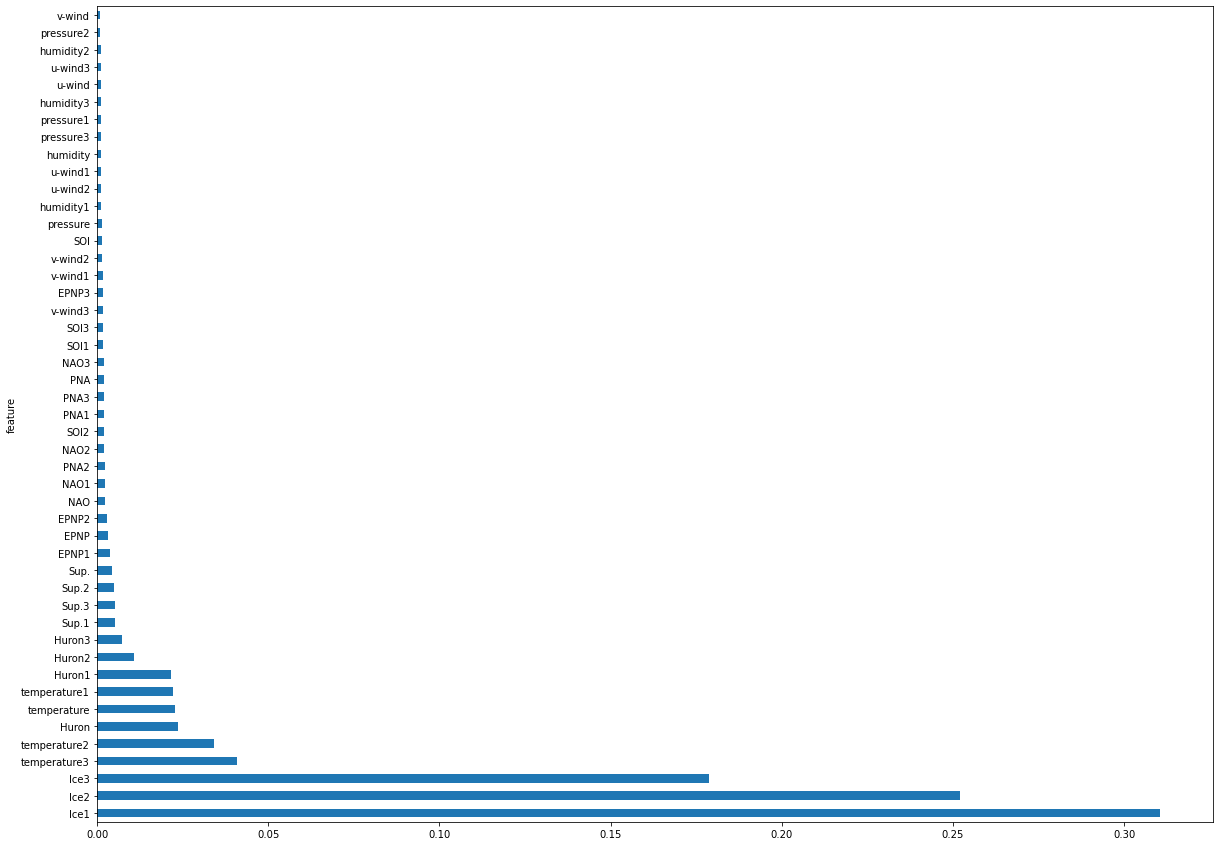

In [40]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<ipython-input-41-785c215a319c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice'] = y_train
<ipython-input-41-785c215a319c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice_pred'] = y_train_pred


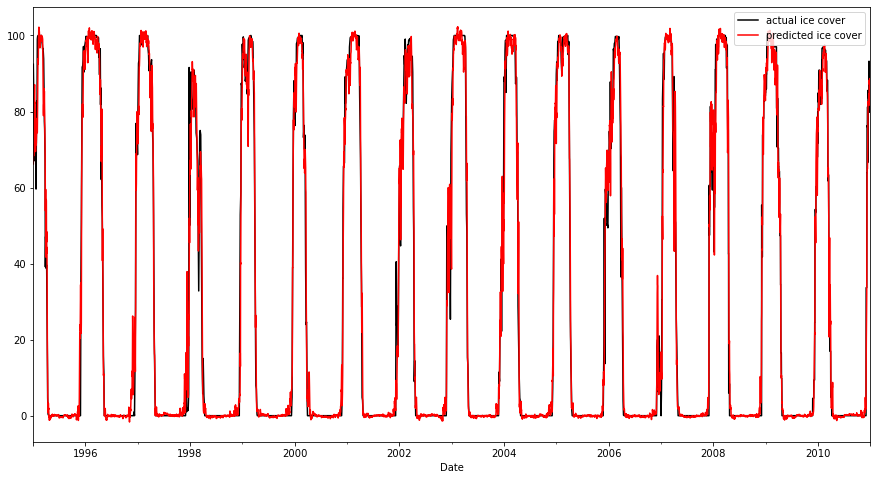

In [41]:
# Overlaying the training predictions on top of training data

X_train['Ice'] = y_train
X_train['Ice_pred'] = y_train_pred

plt.figure(figsize=(15,8))
X_train['Ice'].plot(label = 'actual ice cover', color = 'black')
X_train['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

<ipython-input-42-03a5112f9934>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice'] = y_valid
<ipython-input-42-03a5112f9934>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice_pred'] = y_valid_pred


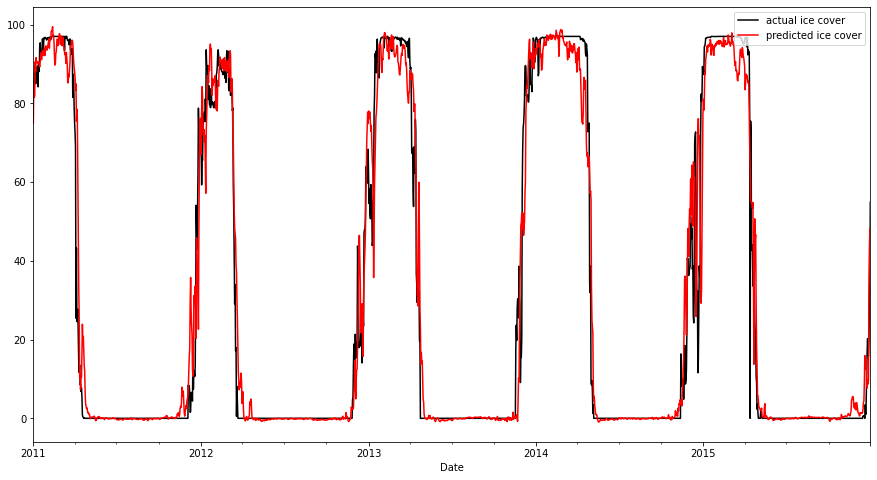

In [42]:
# Overlaying the training predictions on top of validation data

X_valid['Ice'] = y_valid
X_valid['Ice_pred'] = y_valid_pred

plt.figure(figsize=(15,8))
X_valid['Ice'].plot(label = 'actual ice cover', color = 'black')
X_valid['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

In [43]:
# Overlaying the training predictions on top of test data

X_test['Ice'] = y_test
X_test['Ice_pred'] = y_test_pred

plt.figure(figsize=(15,8))
X_test['Ice'].plot(label = 'actual ice cover', color = 'black')
X_test['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

In [44]:
df_period = df_data.reset_index()
df_period['year'] = pd.DatetimeIndex(df_period['Date']).year
df_period['month'] = pd.DatetimeIndex(df_period['Date']).month
df_period['day'] = pd.DatetimeIndex(df_period['Date']).day
df_period = df_period.set_index('Date')
df_period.tail()

Ice  Ice1  Ice2  Ice3    u-wind    v-wind  pressure  humidity  \
Date                                                                        
2021-06-19  0.0   0.0   0.0   0.0  0.620657  0.401869  0.368218  0.360000   
2021-06-20  0.0   0.0   0.0   0.0  0.565975  0.500131  0.377749  0.326957   
2021-06-21  0.0   0.0   0.0   0.0  0.536508  0.449694  0.222665  0.520000   
2021-06-22  0.0   0.0   0.0   0.0  0.591544  0.423147  0.441502  0.274783   
2021-06-23  0.0   0.0   0.0   0.0  0.539980  0.649380  0.512442  0.330435   

            temperature   u-wind1  ...      PNA2     EPNP2      SOI2  \
Date                               ...                                 
2021-06-19     0.742597  0.657628  ...  0.652655  0.391597  0.583333   
2021-06-20     0.725971  0.620657  ...  0.652655  0.391597  0.583333   
2021-06-21     0.708856  0.565975  ...  0.652655  0.391597  0.583333   
2021-06-22     0.653810  0.536508  ...  0.652655  0.391597  0.583333   
2021-06-23     0.716457  0.591544  ...  0.652655  0.391597  0.583333   

                NAO3      PNA3     EPNP3      SOI3  year  month  day  
Date                                                                  
2021-06-19  0.690559  0.652655  0.391597  0.583333  2021      6   19  
2021-06-20  0.690559  0.652655  0.391597  0.583333  2021      6   20  
2021-06-21  0.690559  0.652655  0.391597  0.583333  2021      6   21  
2021-06-22  0.690559  0.652655  0.391597  0.583333  2021      6   22  
2021-06-23  0.690559  0.652655  0.391597  0.583333  2021      6   23  

[5 rows x 51 columns]

In [45]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_freezing = df_period[df_period['month'].isin([10, 11, 12, 1])]
df_freezing = df_freezing[~((df_freezing['month'] == 10) & (df_freezing['day'] < 25))]
df_freezing = df_freezing[~((df_freezing['month'] == 1) & (df_freezing['day'] > 7))]

In [46]:
df_freezing.tail(10)

Ice       Ice1       Ice2       Ice3    u-wind    v-wind  \
Date                                                                         
2020-12-29  32.105606  26.349741  46.203030  24.270012  0.672258  0.504412   
2020-12-30  37.106424  39.406298  26.349741  46.203030  0.481070  0.733693   
2020-12-31  36.241747  37.459853  39.406298  26.349741  0.723274  0.525806   
2021-01-01  36.728748  35.121775  37.459853  39.406298  0.477087  0.671877   
2021-01-02  44.403590  35.647873  35.121775  37.459853  0.488830  0.500377   
2021-01-03  42.457084  44.647313  35.647873  35.121775  0.486259  0.655810   
2021-01-04  46.916322  44.485093  44.647313  35.647873  0.516481  0.714767   
2021-01-05  46.916322  34.997084  44.485093  44.647313  0.484237  0.599350   
2021-01-06  37.417581  32.105606  34.997084  44.485093  0.475588  0.413611   
2021-01-07  38.579701  37.106424  32.105606  34.997084  0.412683  0.410288   

            pressure  humidity  temperature   u-wind1   v-wind1  pressure1  \
Date                                                                         
2020-12-29  0.728192  0.186087     0.357951  0.514569  0.389808   0.432322   
2020-12-30  0.495371  0.354783     0.410719  0.672258  0.504412   0.728192   
2020-12-31  0.496856  0.198261     0.429218  0.481070  0.733693   0.495371   
2021-01-01  0.702215  0.161739     0.404318  0.723274  0.525806   0.496856   
2021-01-02  0.523575  0.193043     0.396543  0.477087  0.671877   0.702215   
2021-01-03  0.503066  0.140870     0.422961  0.488830  0.500377   0.523575   
2021-01-04  0.467206  0.128696     0.445670  0.486259  0.655810   0.503066   
2021-01-05  0.473378  0.222609     0.454050  0.516481  0.714767   0.467206   
2021-01-06  0.682253  0.146087     0.458561  0.484237  0.599350   0.473378   
2021-01-07  0.792023  0.130435     0.397355  0.475588  0.413611   0.682253   

            humidity1  temperature1   u-wind2   v-wind2  pressure2  humidity2  \
Date                                                                            
2020-12-29   0.400000      0.408497  0.541222  0.584182   0.469901   0.363478   
2020-12-30   0.186087      0.357951  0.514569  0.389808   0.432322   0.400000   
2020-12-31   0.354783      0.410719  0.672258  0.504412   0.728192   0.186087   
2021-01-01   0.198261      0.429218  0.481070  0.733693   0.495371   0.354783   
2021-01-02   0.161739      0.404318  0.723274  0.525806   0.496856   0.198261   
2021-01-03   0.193043      0.396543  0.477087  0.671877   0.702215   0.161739   
2021-01-04   0.140870      0.422961  0.488830  0.500377   0.523575   0.193043   
2021-01-05   0.128696      0.445670  0.486259  0.655810   0.503066   0.140870   
2021-01-06   0.222609      0.454050  0.516481  0.714767   0.467206   0.128696   
2021-01-07   0.146087      0.458561  0.484237  0.599350   0.473378   0.222609   

            temperature2   u-wind3   v-wind3  pressure3  humidity3  \
Date                                                                 
2020-12-29      0.385074  0.647396  0.361331   0.317591   0.363478   
2020-12-30      0.408497  0.541222  0.584182   0.469901   0.363478   
2020-12-31      0.357951  0.514569  0.389808   0.432322   0.400000   
2021-01-01      0.410719  0.672258  0.504412   0.728192   0.186087   
2021-01-02      0.429218  0.481070  0.733693   0.495371   0.354783   
2021-01-03      0.404318  0.723274  0.525806   0.496856   0.198261   
2021-01-04      0.396543  0.477087  0.671877   0.702215   0.161739   
2021-01-05      0.422961  0.488830  0.500377   0.523575   0.193043   
2021-01-06      0.445670  0.486259  0.655810   0.503066   0.140870   
2021-01-07      0.454050  0.516481  0.714767   0.467206   0.128696   

            temperature3      Sup.     Huron     Sup.1    Huron1     Sup.2  \
Date                                                                         
2020-12-29      0.366851  0.174801  0.175975  0.176793  0.188387  0.178785   
2020-12-30      0.385074  0.173307  0.175089  0.174801  0.175975  0.176793   
2020-12-31      0.

#### Training XGBoost Model on freezing period

In [47]:
#df_freezing['Ice'] = df_freezing['Ice'].shift(-7)
#df_freezing = df_freezing.dropna()

In [48]:
# Separating the Independent and dependent variables

X = df_freezing.drop(['Ice'], axis = 1)
y = df_freezing['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [49]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
X_train = X['1995-10-25':'2010-01-07']
X_valid = X['2011-10-25':'2015-01-07']
y_train = y['1995-10-25':'2010-01-07']
y_valid = y['2011-10-25':'2015-01-07']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(1125, 47) (1125,)
(300, 47) (300,)


In [50]:
X_test = X['2016-10-25':'2021-01-07']
y_test = y['2016-10-25':'2021-01-07']
print(X_valid.shape, y_valid.shape)

(300, 47) (300,)


In [51]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [0.7, 0.8, 0.9, 1],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [2000, 3000],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[09:17:35] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.689419806328398
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-10-25   0.000000   0.000000   0.000000  0.627832  0.463090  0.553225   
2011-10-26   0.000000   0.000000   0.000000  0.439239  0.393364  0.517677   
2011-10-27   0.000000   0.000000   0.000000  0.456951  0.467111  0.495293   
2011-10-28   0.000000   0.000000   0.000000  0.493836  0.550480  0.5975

In [52]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

6.893559115468561
10.823361799100997


In [53]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

9.88593104503015
15.119281646769517


In [54]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

10.669498744164716
15.615490897244612


In [55]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [56]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<AxesSubplot:ylabel='feature'>

In [57]:
y_train.tail()

Date
2010-01-03    82.431086
2010-01-04    82.431086
2010-01-05    88.390409
2010-01-06    89.647192
2010-01-07    90.876943
Name: Ice, dtype: float64

In [58]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')

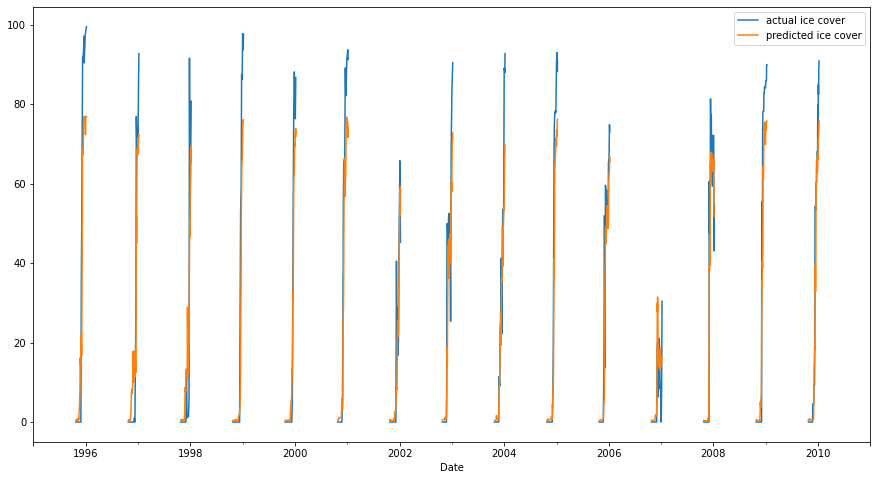

In [59]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

### Modeling for Stable Period

In [60]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
df_stable = df_period[df_period['month'].isin([1, 2, 3])]
df_stable = df_stable[~((df_stable['month'] == 1) & (df_stable['day'] < 8))]
df_stable = df_stable[~((df_stable['month'] == 3) & (df_stable['day'] > 18))]

In [61]:
# Separating the Independent and dependent variables

X = df_stable.drop(['Ice'], axis = 1)
y = df_stable['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [62]:
########## Stable Phase: Jan 15 - Mar 25

X_train = X['1995-01-08':'2010-03-18']
X_valid = X['2011-01-08':'2015-03-18']
y_train = y['1995-01-08':'2010-03-18']
y_valid = y['2011-01-08':'2015-03-18']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(1124, 47) (1124,)
(351, 47) (351,)


In [63]:
X_test = X['2016-01-07':'2021-03-18']
y_test = y['2016-01-07':'2021-03-18']
print(X_valid.shape, y_valid.shape)

(351, 47) (351,)


In [64]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [2000, 3000, 4000],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[09:20:29] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


-2.111187742876903
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-01-08  81.458113  86.511940  79.971685  0.421515  0.320343  0.254619   
2011-01-09  83.295872  81.458113  86.511940  0.520355  0.378385  0.562952   
2011-01-10  85.430759  83.295872  81.458113  0.442138  0.446834  0.774756   
2011-01-11  86.403880  85.430759  83.295872  0.381024  0.408952  0.737

In [65]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

3.045252330589604
3.8279201040720165


In [66]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

3.8864158425346167
7.6828894452254275


In [67]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

6.3108529679308285
9.769567627906417


In [68]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [69]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<AxesSubplot:ylabel='feature'>

In [70]:
y_train.tail()

Date
2010-03-14    63.321685
2010-03-15    63.321685
2010-03-16    48.309528
2010-03-17    40.539282
2010-03-18    33.889997
Name: Ice, dtype: float64

In [71]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')

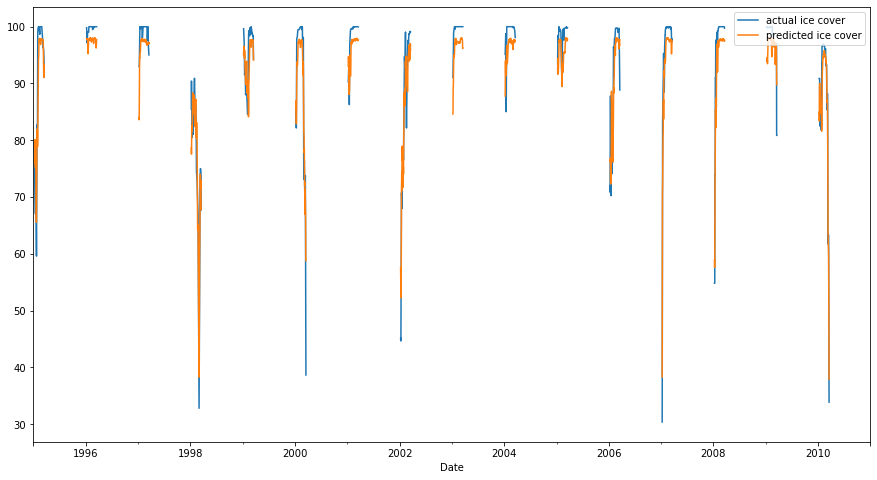

In [72]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

### Modeling for Melting Period

In [73]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
df_melting = df_period[df_period['month'].isin([3, 4, 5])]
df_melting = df_melting[~((df_melting['month'] == 3) & (df_melting['day'] < 19))]
df_melting = df_melting[~((df_melting['month'] == 5) & (df_melting['day'] > 3))]

In [74]:
# Separating the Independent and dependent variables

X = df_melting.drop(['Ice'], axis = 1)
y = df_melting['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [75]:
########## Melting Phase: Mar 26 - May 10

X_train = X['1995-03-19':'2010-05-03']
X_valid = X['2011-03-19':'2015-05-03']
y_train = y['1995-03-19':'2010-05-03']
y_valid = y['2011-03-19':'2015-05-03']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(736, 47) (736,)
(230, 47) (230,)


In [76]:
X_test = X['2016-03-19':'2021-05-03']
y_test = y['2016-03-19':'2021-05-03']
print(X_valid.shape, y_valid.shape)

(230, 47) (230,)


In [77]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005],
              'max_depth': [3],
              'subsample': [1],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [2500, 3000],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[09:24:17] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8495455380118792
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-03-19  97.025528  93.430902  97.025528  0.572687  0.390273  0.762608   
2011-03-20  97.025528  97.025528  93.430902  0.375250  0.698119  0.817220   
2011-03-21  96.620038  97.025528  97.025528  0.413743  0.609205  0.495097   
2011-03-22  97.025528  96.620038  97.025528  0.392255  0.353973  0.634

In [78]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

3.191427616936405
4.614684279207357


In [79]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

12.104403909223828
15.74906036669887


In [80]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

10.205788950121438
13.520048563840216


In [81]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

<AxesSubplot:ylabel='feature'>

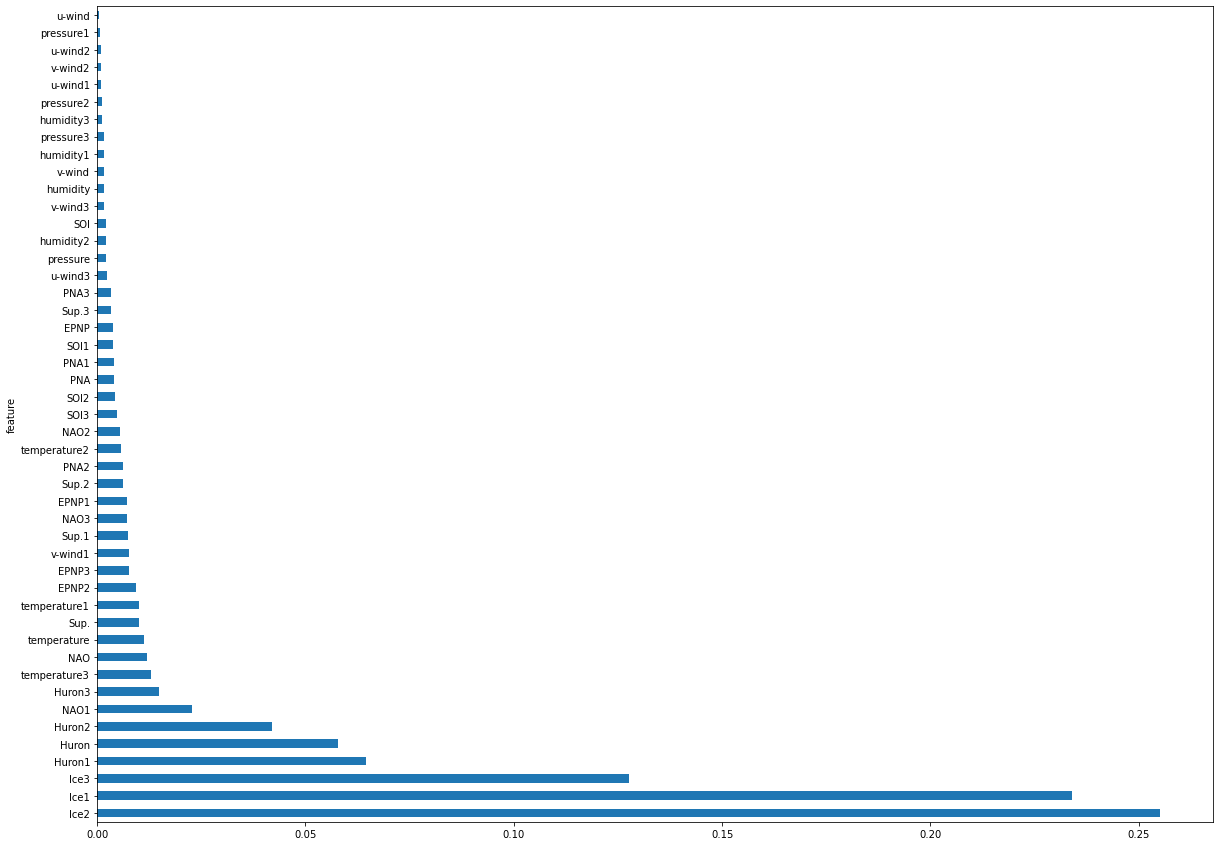

In [82]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [83]:
y_train.tail()

Date
2010-04-29    0.0
2010-04-30    0.0
2010-05-01    0.0
2010-05-02    0.0
2010-05-03    0.0
Name: Ice, dtype: float64

In [84]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')

In [85]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

# 30 Day forecast

In [86]:
df_data = ice_data.merge(df_norm, on = 'Date', how = 'inner')
df_data = df_data.set_index('Date')
df_data.head(10)

Ice       Ice1  Ice2  Ice3    u-wind    v-wind  pressure  \
Date                                                                         
1995-01-01   0.000000        NaN   NaN   NaN  0.615115  0.473178  0.516700   
1995-01-02   0.000000   0.000000   NaN   NaN  0.711702  0.427545  0.410524   
1995-01-03   0.000000   0.000000   0.0   NaN  0.823125  0.550553  0.469706   
1995-01-04   0.000000   0.000000   0.0   0.0  0.693539  0.417617  0.548576   
1995-01-05   0.000000   0.000000   0.0   0.0  0.908127  0.696900  0.491621   
1995-01-06   0.000000   0.000000   0.0   0.0  0.812893  0.670948  0.310442   
1995-01-07   0.000000   0.000000   0.0   0.0  0.481618  0.299704  0.388609   
1995-01-08   0.000000   0.000000   0.0   0.0  0.693795  0.656318  0.402438   
1995-01-09  62.446242   0.000000   0.0   0.0  0.712981  0.459854  0.593343   
1995-01-10  77.650264  62.446242   0.0   0.0  0.346039  0.405817  0.762569   

            humidity  temperature   u-wind1   v-wind1  pressure1  humidity1  \
Date                                                                          
1995-01-01  0.384348     0.417669       NaN       NaN        NaN        NaN   
1995-01-02  0.316522     0.372446  0.615115  0.473178   0.516700   0.384348   
1995-01-03  0.200000     0.334305  0.711702  0.427545   0.410524   0.316522   
1995-01-04  0.064348     0.222110  0.823125  0.550553   0.469706   0.200000   
1995-01-05  0.193043     0.314086  0.693539  0.417617   0.548576   0.064348   
1995-01-06  0.469565     0.396245  0.908127  0.696900   0.491621   0.193043   
1995-01-07  0.073043     0.271408  0.812893  0.670948   0.310442   0.469565   
1995-01-08  0.123478     0.317334  0.481618  0.299704   0.388609   0.073043   
1995-01-09  0.074783     0.283050  0.693795  0.656318   0.402438   0.123478   
1995-01-10  0.163478     0.196717  0.712981  0.459854   0.593343   0.074783   

            temperature1   u-wind2   v-wind2  pressure2  humidity2  \
Date                                                                 
1995-01-01           NaN       NaN       NaN        NaN        NaN   
1995-01-02      0.417669       NaN       NaN        NaN        NaN   
1995-01-03      0.372446  0.615115  0.473178   0.516700   0.384348   
1995-01-04      0.334305  0.711702  0.427545   0.410524   0.316522   
1995-01-05      0.222110  0.823125  0.550553   0.469706   0.200000   
1995-01-06      0.314086  0.693539  0.417617   0.548576   0.064348   
1995-01-07      0.396245  0.908127  0.696900   0.491621   0.193043   
1995-01-08      0.271408  0.812893  0.670948   0.310442   0.469565   
1995-01-09      0.317334  0.481618  0.299704   0.388609   0.073043   
1995-01-10      0.283050  0.693795  0.656318   0.402438   0.123478   

            temperature2   u-wind3   v-wind3  pressure3  humidity3  \
Date                                                                 
1995-01-01           NaN       NaN       NaN        NaN        NaN   
1995-01-02           NaN       NaN       NaN        NaN        NaN   
1995-01-03      0.417669       NaN       NaN        NaN        NaN   
1995-01-04      0.372446  0.615115  0.473178   0.516700   0.384348   
1995-01-05      0.334305  0.711702  0.427545   0.410524   0.316522   
1995-01-06      0.222110  0.823125  0.550553   0.469706   0.200000   
1995-01-07      0.314086  0.693539  0.417617   0.548576   0.064348   
1995-01-08      0.396245  0.908127  0.696900   0.491621   0.193043   
1995-01-09      0.271408  0.812893  0.670948   0.310442   0.469565   
1995-01-10      0.317334  0.481618  0.299704   0.388609   0.073043   

            temperature3      Sup.     Huron     Sup.1    Huron1     Sup.2  \
Date                                                                         
1995-01-01           NaN  0.153884  0.190603       NaN       NaN       NaN   
1995-01-02           NaN  0.153386  0.188387  0.153884  0.190603       NaN   
1995-01-03           NaN  0.152888  0.185727  0.153386  0.188387  0.153884   
1995-01-04      0.417669  0.152888  0.183067  0.152888  0.18

In [87]:
df_data.tail(10)

Ice  Ice1  Ice2  Ice3    u-wind    v-wind  pressure  humidity  \
Date                                                                        
2021-06-21  0.0   0.0   0.0   0.0  0.536508  0.449694  0.222665  0.520000   
2021-06-22  0.0   0.0   0.0   0.0  0.591544  0.423147  0.441502  0.274783   
2021-06-23  0.0   0.0   0.0   0.0  0.539980  0.649380  0.512442  0.330435   
2021-06-24  0.0   0.0   0.0   0.0  0.611472  0.784246  0.472128  0.518261   
2021-06-25  0.0   0.0   0.0   0.0  0.462518  0.629235  0.481151  0.605217   
2021-06-26  0.0   0.0   0.0   0.0  0.427313  0.540233  0.454510  0.457391   
2021-06-27  0.0   0.0   0.0   0.0  0.453114  0.452684  0.406305  0.697391   
2021-06-28  0.0   0.0   0.0   0.0  0.546229  0.513905  0.564749  0.551304   
2021-06-29  0.0   0.0   0.0   0.0  0.473042  0.607013  0.604711  0.615652   
2021-06-30  0.0   0.0   0.0   0.0  0.601301  0.523049  0.537169  0.568696   

            temperature   u-wind1   v-wind1  pressure1  humidity1  \
Date                                                                
2021-06-21     0.708856  0.565975  0.500131   0.377749   0.326957   
2021-06-22     0.653810  0.536508  0.449694   0.222665   0.520000   
2021-06-23     0.716457  0.591544  0.423147   0.441502   0.274783   
2021-06-24     0.798457  0.539980  0.649380   0.512442   0.330435   
2021-06-25     0.767096  0.611472  0.784246   0.472128   0.518261   
2021-06-26     0.777870  0.462518  0.629235   0.481151   0.605217   
2021-06-27     0.793817  0.427313  0.540233   0.454510   0.457391   
2021-06-28     0.839706  0.453114  0.452684   0.406305   0.697391   
2021-06-29     0.830244  0.546229  0.513905   0.564749   0.551304   
2021-06-30     0.818099  0.473042  0.607013   0.604711   0.615652   

            temperature1   u-wind2   v-wind2  pressure2  humidity2  \
Date                                                                 
2021-06-21      0.725971  0.620657  0.401869   0.368218   0.360000   
2021-06-22      0.708856  0.565975  0.500131   0.377749   0.326957   
2021-06-23      0.653810  0.536508  0.449694   0.222665   0.520000   
2021-06-24      0.716457  0.591544  0.423147   0.441502   0.274783   
2021-06-25      0.798457  0.539980  0.649380   0.512442   0.330435   
2021-06-26      0.767096  0.611472  0.784246   0.472128   0.518261   
2021-06-27      0.777870  0.462518  0.629235   0.481151   0.605217   
2021-06-28      0.793817  0.427313  0.540233   0.454510   0.457391   
2021-06-29      0.839706  0.453114  0.452684   0.406305   0.697391   
2021-06-30      0.830244  0.546229  0.513905   0.564749   0.551304   

            temperature2   u-wind3   v-wind3  pressure3  humidity3  \
Date                                                                 
2021-06-21      0.742597  0.657628  0.577187   0.334036   0.379130   
2021-06-22      0.725971  0.620657  0.401869   0.368218   0.360000   
2021-06-23      0.708856  0.565975  0.500131   0.377749   0.326957   
2021-06-24      0.653810  0.536508  0.449694   0.222665   0.520000   
2021-06-25      0.716457  0.591544  0.423147   0.441502   0.274783   
2021-06-26      0.798457  0.539980  0.649380   0.512442   0.330435   
2021-06-27      0.767096  0.611472  0.784246   0.472128   0.518261   
2021-06-28      0.777870  0.462518  0.629235   0.481151   0.605217   
2021-06-29      0.793817  0.427313  0.540233   0.454510   0.457391   
2021-06-30      0.839706  0.453114  0.452684   0.406305   0.697391   

            temperature3      Sup.     Huron     Sup.1    Huron1     Sup.2  \
Date                                                                         
2021-06-21      0.824687  0.367032  0.628546  0.369522  0.642287  0.370518   
2021-06-22      0.742597  0.372012  0.609929  0.367032  0.628546  0.369522   
2021-06-23      0.725971  0.383466  0.603280  0.372012  0.609929  0.367032   
2021-06-24      0.708856  0.400896  0.609486  0.383466  0.603280  0.372012   
2021-06-25      0.653810  0.423805  0.625887  0.400896  0.609486  0.383466   
2021-06-26      0.716457  0.46

In [88]:
df_data['Ice'] = df_data['Ice'].shift(-30)
df_data = df_data.dropna()

In [89]:
X = df_data.drop(['Ice'], axis = 1) ####### This is to include ice lags
###### X = df_data.drop(['Ice', 'Ice1', 'Ice2', 'Ice3'], axis = 1) ########## This is to exclude ice lags
y = df_data['Ice']

In [90]:
X_train = X['1995-01-01':'2010-12-31']
X_valid = X['2011-01-01':'2015-12-31']
y_train = y['1995-01-01':'2010-12-31']
y_valid = y['2011-01-01':'2015-12-31']

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(5841, 47) (5841,)
(1826, 47) (1826,)


In [91]:
X_test = X['2016-01-01':'2021-06-30']
y_test = y['2016-01-01':'2021-06-30']
print(X_test.shape, y_test.shape)

(1978, 47) (1978,)


In [92]:
# Running the XGBoost regressor with a wide range of hyper parameters and timeseries split
import time
t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree', 'gblinear'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.005],
              'max_depth': [3],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [1500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[09:27:23] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.6950319570898038
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-01-01  90.160346  89.930617  93.241438  0.494847  0.702764  0.300207   
2011-01-02  90.160346  90.160346  89.930617  0.761438  0.670542  0.419040   
2011-01-03  85.904482  90.160346  90.160346  0.656702  0.591091  0.508692   
2011-01-04  79.836571  85.904482  90.160346  0.519295  0.520480  0.421

In [93]:
# Predicting on the Training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

7.4189847555435975
12.81420021903409


In [94]:
# Predicting on the Validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

10.935650414061755
19.224075214318773


In [95]:
# Predicting on the test data and calculating the mean absolute error

X_test = X_test.dropna()
y_test = y_test.dropna()

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

11.884885842172968
20.317358737723104


<AxesSubplot:ylabel='feature'>

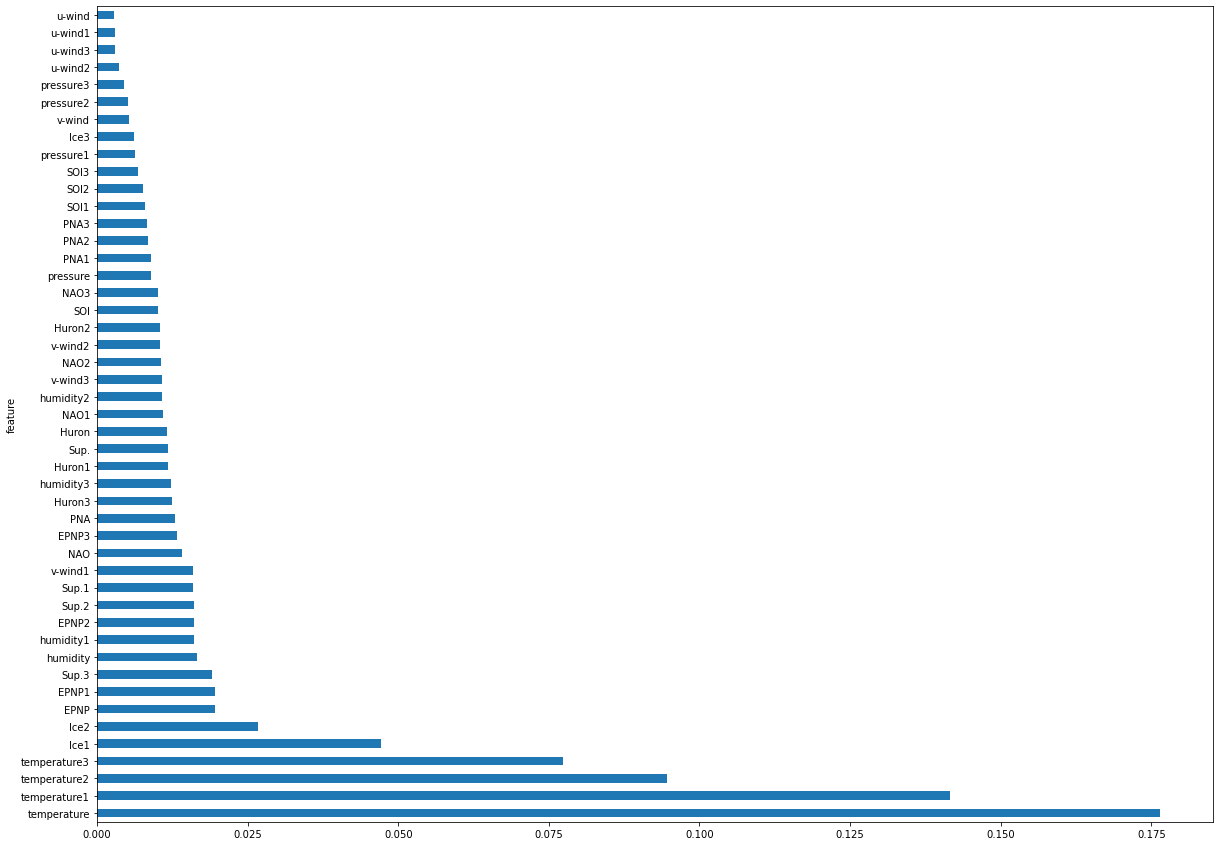

In [96]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<ipython-input-97-785c215a319c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice'] = y_train
<ipython-input-97-785c215a319c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice_pred'] = y_train_pred


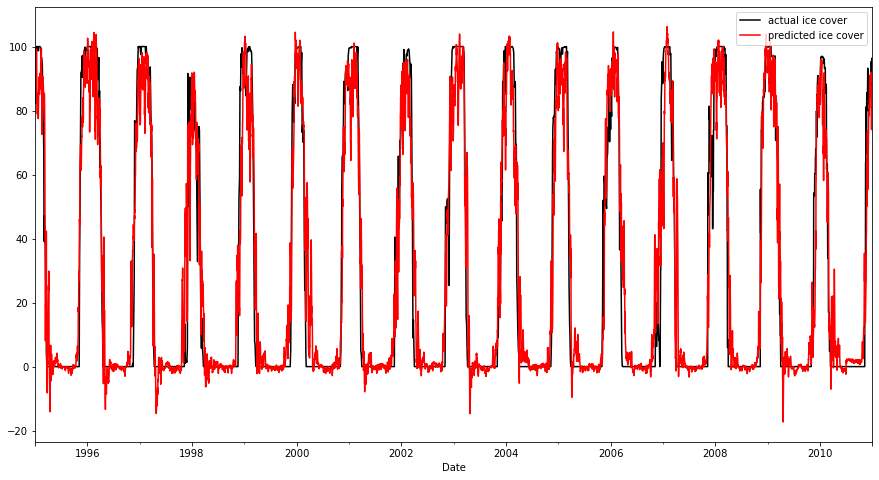

In [97]:
# Overlaying the training predictions on top of training data

X_train['Ice'] = y_train
X_train['Ice_pred'] = y_train_pred

plt.figure(figsize=(15,8))
X_train['Ice'].plot(label = 'actual ice cover', color = 'black')
X_train['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

<ipython-input-98-03a5112f9934>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice'] = y_valid
<ipython-input-98-03a5112f9934>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice_pred'] = y_valid_pred


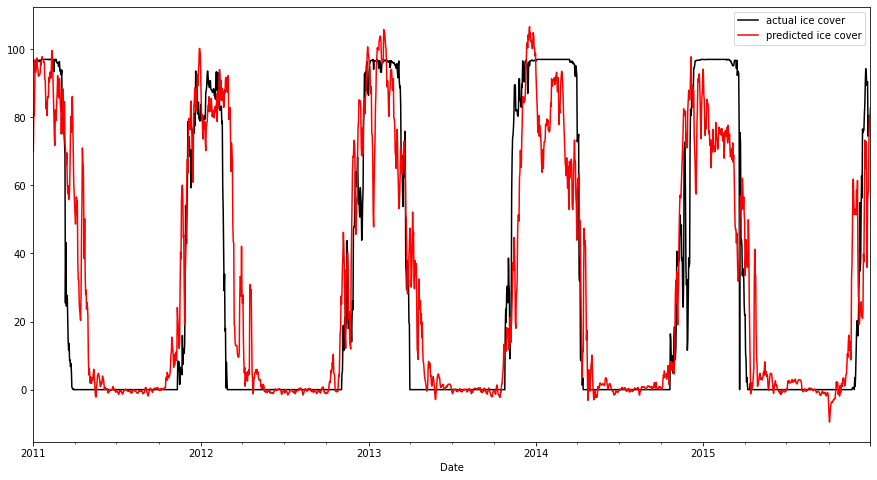

In [98]:
# Overlaying the training predictions on top of validation data

X_valid['Ice'] = y_valid
X_valid['Ice_pred'] = y_valid_pred

plt.figure(figsize=(15,8))
X_valid['Ice'].plot(label = 'actual ice cover', color = 'black')
X_valid['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

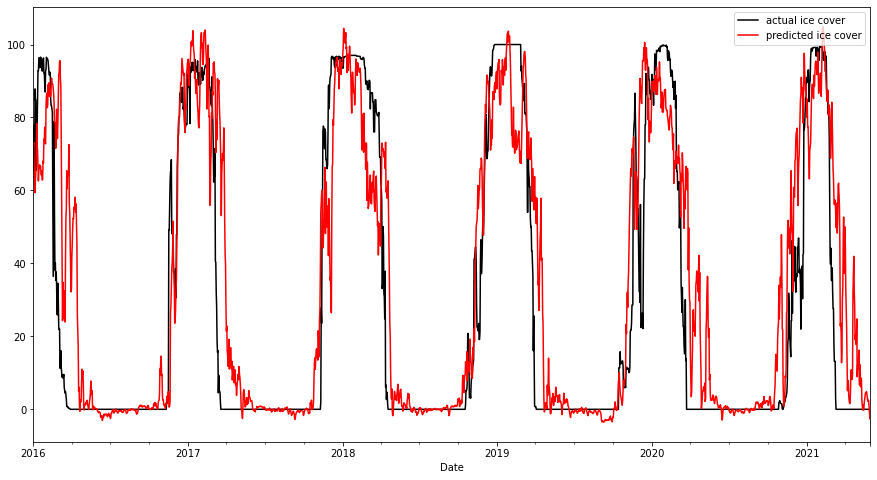

In [99]:
# Overlaying the training predictions on top of test data

X_test['Ice'] = y_test
X_test['Ice_pred'] = y_test_pred

plt.figure(figsize=(15,8))
X_test['Ice'].plot(label = 'actual ice cover', color = 'black')
X_test['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

In [100]:
df_period = df_data.reset_index()
df_period['year'] = pd.DatetimeIndex(df_period['Date']).year
df_period['month'] = pd.DatetimeIndex(df_period['Date']).month
df_period['day'] = pd.DatetimeIndex(df_period['Date']).day
df_period = df_period.set_index('Date')
df_period.tail()

Ice  Ice1  Ice2  Ice3    u-wind    v-wind  pressure  humidity  \
Date                                                                        
2021-05-27  0.0   0.0   0.0   0.0  0.535265  0.343435  0.662995  0.147826   
2021-05-28  0.0   0.0   0.0   0.0  0.340472  0.414526  0.678191  0.102609   
2021-05-29  0.0   0.0   0.0   0.0  0.444392  0.465892  0.677995  0.140870   
2021-05-30  0.0   0.0   0.0   0.0  0.540589  0.561758  0.691433  0.168696   
2021-05-31  0.0   0.0   0.0   0.0  0.553818  0.656347  0.654205  0.304348   

            temperature   u-wind1   v-wind1  pressure1  humidity1  \
Date                                                                
2021-05-27     0.598303  0.773815  0.545038   0.398726   0.382609   
2021-05-28     0.623193  0.535265  0.343435   0.662995   0.147826   
2021-05-29     0.648676  0.340472  0.414526   0.678191   0.102609   
2021-05-30     0.658675  0.444392  0.465892   0.677995   0.140870   
2021-05-31     0.686789  0.540589  0.561758   0.691433   0.168696   

            temperature1   u-wind2   v-wind2  pressure2  humidity2  \
Date                                                                 
2021-05-27      0.765054  0.528115  0.669192   0.470097   0.620870   
2021-05-28      0.598303  0.773815  0.545038   0.398726   0.382609   
2021-05-29      0.623193  0.535265  0.343435   0.662995   0.147826   
2021-05-30      0.648676  0.340472  0.414526   0.678191   0.102609   
2021-05-31      0.658675  0.444392  0.465892   0.677995   0.140870   

            temperature2   u-wind3   v-wind3  pressure3  humidity3  \
Date                                                                 
2021-05-27      0.765192  0.356844  0.627740   0.658737   0.438261   
2021-05-28      0.765054  0.528115  0.669192   0.470097   0.620870   
2021-05-29      0.598303  0.773815  0.545038   0.398726   0.382609   
2021-05-30      0.623193  0.535265  0.343435   0.662995   0.147826   
2021-05-31      0.648676  0.340472  0.414526   0.678191   0.102609   

            temperature3      Sup.     Huron     Sup.1    Huron1     Sup.2  \
Date                                                                         
2021-05-27      0.676849  0.209661  0.361259  0.215637  0.369681  0.231574   
2021-05-28      0.765192  0.212649  0.367908  0.209661  0.361259  0.215637   
2021-05-29      0.765054  0.219124  0.376773  0.212649  0.367908  0.209661   
2021-05-30      0.598303  0.220120  0.391401  0.219124  0.376773  0.212649   
2021-05-31      0.623193  0.219622  0.406472  0.220120  0.391401  0.219124   

              Huron2     Sup.3    Huron3       NAO       PNA      EPNP  SOI  \
Date                                                                          
2021-05-27  0.376330  0.236554  0.371454  0.339161  0.205752  0.435294  0.6   
2021-05-28  0.369681  0.231574  0.376330  0.339161  0.205752  0.435294  0.6   
2021-05-29  0.361259  0.215637  0.369681  0.339161  0.205752  0.435294  0.6   
2021-05-30  0.367908  0.209661  0.361259  0.339161  0.205752  0.435294  0.6   
2021-05-31  0.376773  0.212649  0.367908  0.339161  0.205752  0.435294  0.6   

                NAO1      PNA1     EPNP1  SOI1      NAO2      PNA2     EPNP2  \
Date                                                                           
2021-05-27  0.339161  0.205752  0.435294   0.6  0.339161  0.205752  0.435294   
2021-05-28  0.339161  0.205752  0.435294   0.6  0.339161  0.205752  0.435294   
2021-05-29  0.339161  0.205752  0.435294   0.6  0.339161  0.205752  0.435294   
2021-05-30  0.339161  0.205752  0.435294   0.6  0.339161  0.205752  0.435294   
2021-05-31  0.339161  0.205752  0.435294   0.6  0.339161  0.205752  0.435294   

            SOI2      NAO3      PNA3     EPNP3  SOI3  year  month  day  
Date                                                                    
2021-05-27   0.6  0.339161  0.205752  0.435294   0.6  2021      5   27  
2021-05-28   0.6  0.339161  0.205752  0.435294   0.6  2021      5   28  
2021-05-29   0.6  0.339161  0.205752  0.435294   0.6

In [101]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_freezing = df_period[df_period['month'].isin([10, 11, 12])]
df_freezing = df_freezing[~((df_freezing['month'] == 10) & (df_freezing['day'] < 2))]
df_freezing = df_freezing[~((df_freezing['month'] == 12) & (df_freezing['day'] > 15))]

In [102]:
df_freezing.tail(10)

Ice      Ice1      Ice2      Ice3    u-wind    v-wind  \
Date                                                                      
2020-12-06  32.105606  0.000000  0.162135  1.513259  0.487356  0.470812   
2020-12-07  37.106424  0.000000  0.000000  0.162135  0.470119  0.448402   
2020-12-08  36.241747  0.540450  0.000000  0.000000  0.559104  0.580917   
2020-12-09  36.728748  1.945619  0.540450  0.000000  0.708412  0.495109   
2020-12-10  44.403590  1.945619  1.945619  0.540450  0.553964  0.554602   
2020-12-11  42.457084  1.945619  1.945619  1.945619  0.488671  0.447270   
2020-12-12  46.916322  2.243207  1.945619  1.945619  0.292525  0.338529   
2020-12-13  46.916322  3.459497  2.243207  1.945619  0.541478  0.311867   
2020-12-14  37.417581  3.459497  3.459497  2.243207  0.642097  0.524036   
2020-12-15  38.579701  4.202848  3.459497  3.459497  0.584125  0.406587   

            pressure  humidity  temperature   u-wind1   v-wind1  pressure1  \
Date                                                                         
2020-12-06  0.597250  0.273043     0.384842  0.516615  0.388124   0.587640   
2020-12-07  0.545451  0.340870     0.422498  0.487356  0.470812   0.597250   
2020-12-08  0.492793  0.288696     0.436664  0.470119  0.448402   0.545451   
2020-12-09  0.304114  0.466087     0.496487  0.559104  0.580917   0.492793   
2020-12-10  0.478104  0.377391     0.509554  0.708412  0.495109   0.304114   
2020-12-11  0.507754  0.396522     0.515744  0.553964  0.554602   0.478104   
2020-12-12  0.563342  0.363478     0.430263  0.488671  0.447270   0.507754   
2020-12-13  0.512872  0.273043     0.382559  0.292525  0.338529   0.563342   
2020-12-14  0.479941  0.226087     0.411726  0.541478  0.311867   0.512872   
2020-12-15  0.713739  0.168696     0.346802  0.642097  0.524036   0.479941   

            humidity1  temperature1   u-wind2   v-wind2  pressure2  humidity2  \
Date                                                                            
2020-12-06   0.297391      0.428182  0.631962  0.473874   0.375327   0.349565   
2020-12-07   0.273043      0.384842  0.516615  0.388124   0.587640   0.297391   
2020-12-08   0.340870      0.422498  0.487356  0.470812   0.597250   0.273043   
2020-12-09   0.288696      0.436664  0.470119  0.448402   0.545451   0.340870   
2020-12-10   0.466087      0.496487  0.559104  0.580917   0.492793   0.288696   
2020-12-11   0.377391      0.509554  0.708412  0.495109   0.304114   0.466087   
2020-12-12   0.396522      0.515744  0.553964  0.554602   0.478104   0.377391   
2020-12-13   0.363478      0.430263  0.488671  0.447270   0.507754   0.396522   
2020-12-14   0.273043      0.382559  0.292525  0.338529   0.563342   0.363478   
2020-12-15   0.226087      0.411726  0.541478  0.311867   0.512872   0.273043   

            temperature2   u-wind3   v-wind3  pressure3  humidity3  \
Date                                                                 
2020-12-06      0.483283  0.741680  0.488026   0.470448   0.361739   
2020-12-07      0.428182  0.631962  0.473874   0.375327   0.349565   
2020-12-08      0.384842  0.516615  0.388124   0.587640   0.297391   
2020-12-09      0.422498  0.487356  0.470812   0.597250   0.273043   
2020-12-10      0.436664  0.470119  0.448402   0.545451   0.340870   
2020-12-11      0.496487  0.559104  0.580917   0.492793   0.288696   
2020-12-12      0.509554  0.708412  0.495109   0.304114   0.466087   
2020-12-13      0.515744  0.553964  0.554602   0.478104   0.377391   
2020-12-14      0.430263  0.488671  0.447270   0.507754   0.396522   
2020-12-15      0.382559  0.292525  0.338529   0.563342   0.363478   

            temperature3      Sup.     Huron     Sup.1    Huron1     Sup.2  \
Date                                                                         
2020-12-06      0.483686  0.239542  0.284574  0.240538  0.290337  0.241534   
2020-12-07      0.483283  0.238546  0.280585  0.239542  0.284574  0.240538   
2020-12-08      0.428182  0.238048  0.277482  0.238546

#### Training XGBoost Model on freezing period

In [103]:
#df_freezing['Ice'] = df_freezing['Ice'].shift(-7)
#df_freezing = df_freezing.dropna()

In [104]:
# Separating the Independent and dependent variables

X = df_freezing.drop(['Ice'], axis = 1)
y = df_freezing['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [105]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
X_train = X['1995-10-02':'2010-12-15']
X_valid = X['2011-10-02':'2015-12-15']
y_train = y['1995-10-02':'2010-12-15']
y_valid = y['2011-10-02':'2015-12-15']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(1200, 47) (1200,)
(375, 47) (375,)


In [106]:
X_test = X['2016-10-02':'2021-12-15']
y_test = y['2016-10-02':'2021-12-15']
print(X_valid.shape, y_valid.shape)

(375, 47) (375,)


In [107]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [1],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [3000],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[09:28:19] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.2680252827574673
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-10-02   0.000000   0.000000   0.000000  0.528529  0.410244  0.652486   
2011-10-03   0.000000   0.000000   0.000000  0.499391  0.351055  0.633931   
2011-10-04   0.000000   0.000000   0.000000  0.473371  0.499710  0.665573   
2011-10-05   0.000000   0.000000   0.000000  0.439300  0.544573  0.67760

In [108]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

7.714867831313328
11.65882150078024


In [109]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

12.824411814726579
16.763264650375113


In [110]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

12.5727091947388
18.41700083925697


In [111]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

<AxesSubplot:ylabel='feature'>

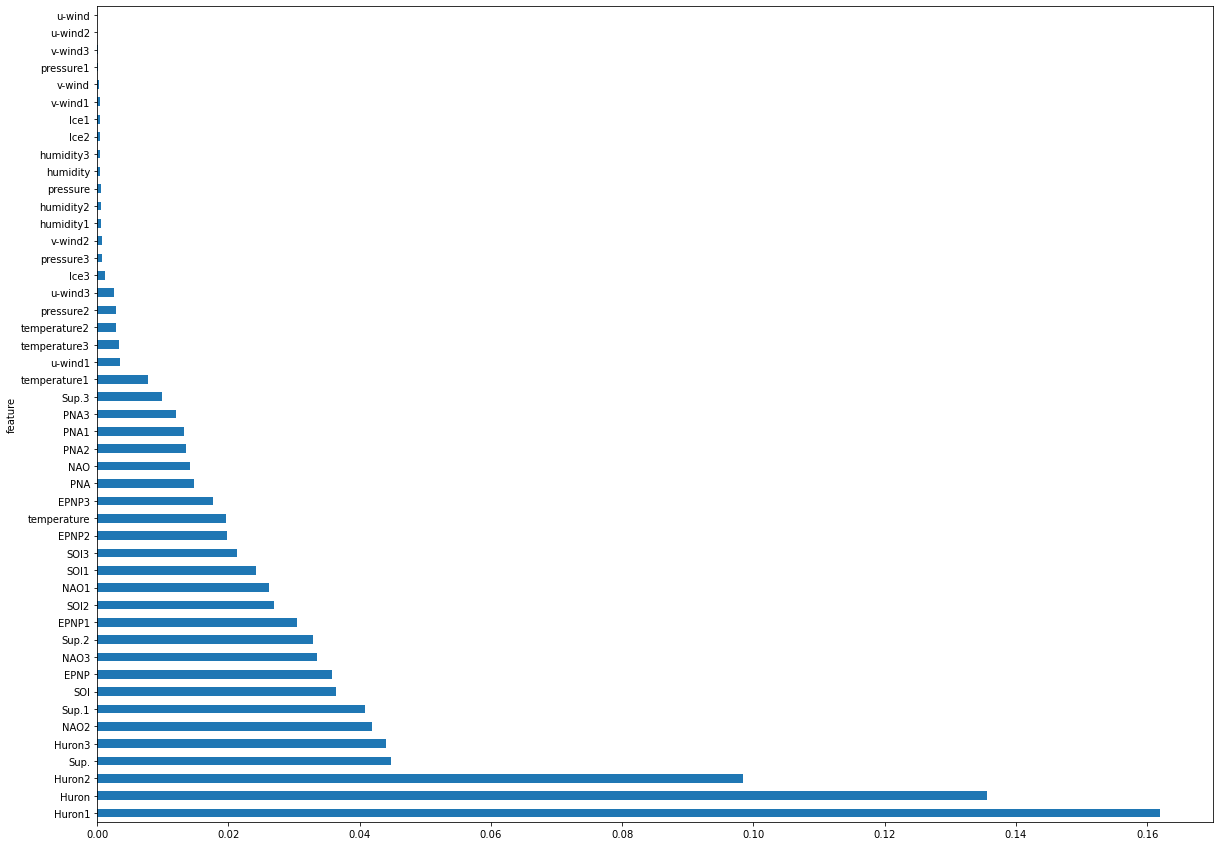

In [112]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [113]:
y_train.tail()

Date
2010-12-11    86.403880
2010-12-12    89.133615
2010-12-13    85.539200
2010-12-14    84.998770
2010-12-15    85.133420
Name: Ice, dtype: float64

In [114]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')

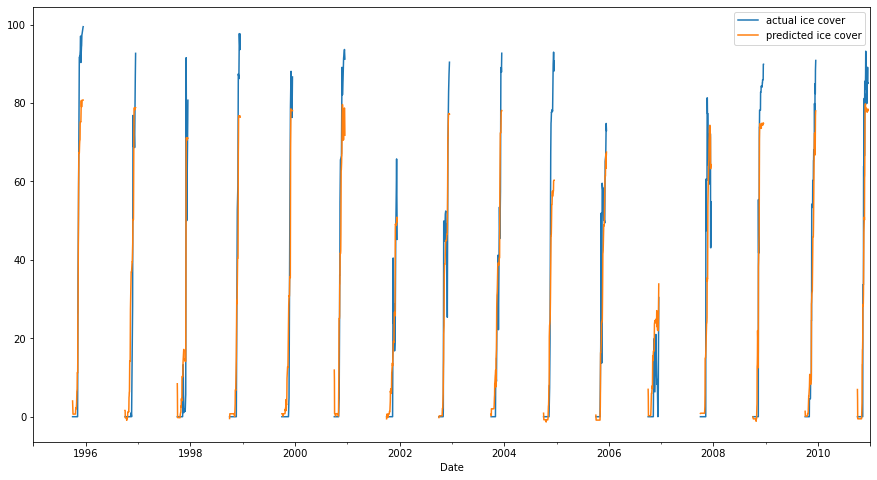

In [115]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

### Modeling for Stable Period

In [116]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
df_stable = df_period[df_period['month'].isin([12, 1, 2])]
df_stable = df_stable[~((df_stable['month'] == 12) & (df_stable['day'] < 16))]
df_stable = df_stable[~((df_stable['month'] == 2) & (df_stable['day'] > 23))]

In [117]:
# Separating the Independent and dependent variables

X = df_stable.drop(['Ice'], axis = 1)
y = df_stable['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [118]:
########## Stable Phase: Jan 15 - Mar 25

X_train = X['1995-12-16':'2010-02-23']
X_valid = X['2011-12-16':'2015-02-23']
y_train = y['1995-12-16':'2010-02-23']
y_valid = y['2011-12-16':'2015-02-23']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(1050, 47) (1050,)
(280, 47) (280,)


In [119]:
X_test = X['2016-12-16':'2021-02-23']
y_test = y['2016-12-16':'2021-02-23']
print(X_valid.shape, y_valid.shape)

(280, 47) (280,)


In [120]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [1],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [5500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[09:29:32] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


-17.78571978644124
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-12-16   6.054193   8.269934   5.783865  0.681187  0.330808  0.529162   
2011-12-17   1.513548   6.054193   8.269934  0.482909  0.499753  0.692449   
2011-12-18   1.729769   1.513548   6.054193  0.567607  0.676493  0.537834   
2011-12-19   6.594746   1.729769   1.513548  0.667081  0.560219  0.36005

In [121]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

3.1159326553246522
4.520840003981335


In [122]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

5.9427181837457494
11.36927471676989


In [123]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

6.41021650713475
9.707731136624417


In [124]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

<AxesSubplot:ylabel='feature'>

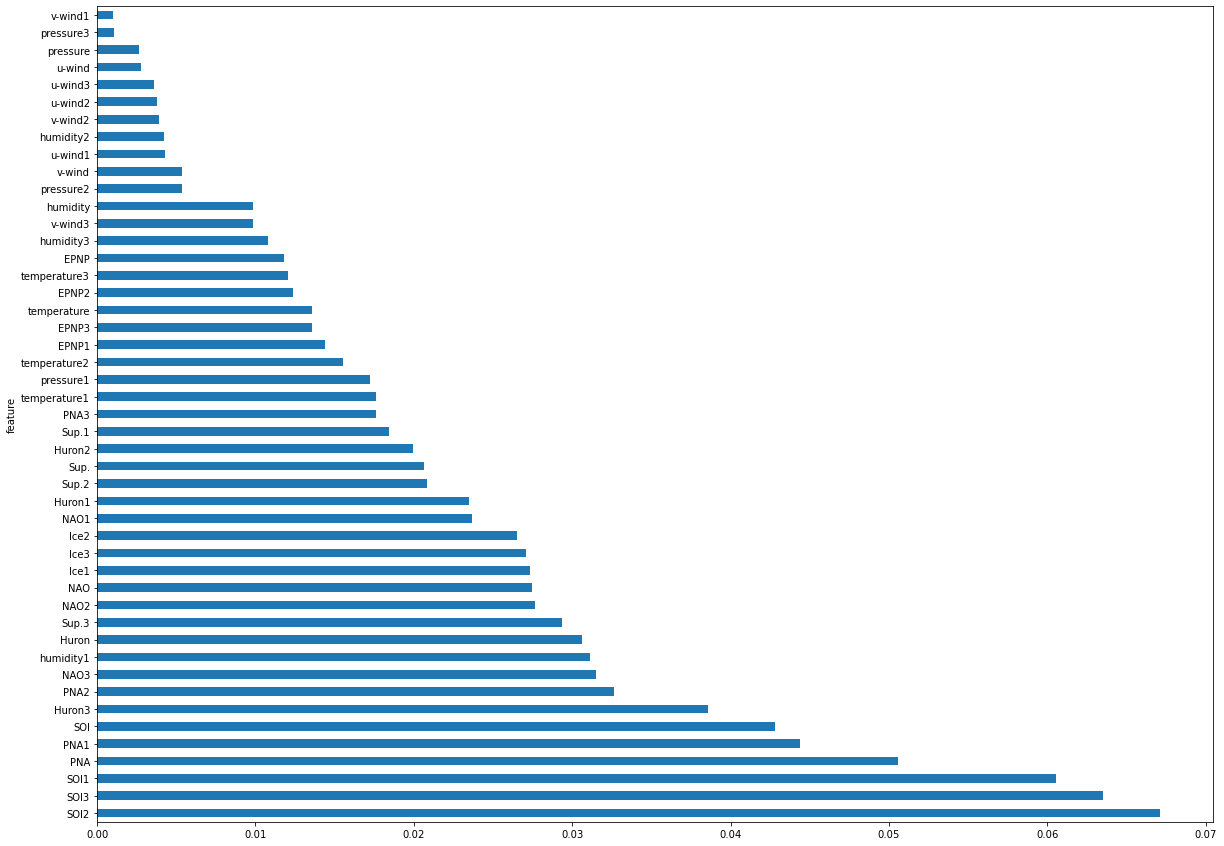

In [125]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [126]:
y_train.tail()

Date
2010-02-19    63.321685
2010-02-20    63.321685
2010-02-21    48.309528
2010-02-22    40.539282
2010-02-23    33.889997
Name: Ice, dtype: float64

In [127]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')

In [128]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

### Modeling for Melting Period

In [129]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
df_melting = df_period[df_period['month'].isin([2, 3, 4])]
df_melting = df_melting[~((df_melting['month'] == 2) & (df_melting['day'] < 24))]
df_melting = df_melting[~((df_melting['month'] == 4) & (df_melting['day'] > 10))]

In [130]:
# Separating the Independent and dependent variables

X = df_melting.drop(['Ice'], axis = 1)
y = df_melting['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [131]:
########## Melting Phase: Mar 26 - May 10

X_train = X['1995-02-24':'2010-04-10']
X_valid = X['2011-02-24':'2015-04-10']
y_train = y['1995-02-24':'2010-04-10']
y_valid = y['2011-02-24':'2015-04-10']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(740, 47) (740,)
(231, 47) (231,)


In [132]:
X_test = X['2016-02-24':'2021-04-10']
y_test = y['2016-02-24':'2021-04-10']
print(X_valid.shape, y_valid.shape)

(231, 47) (231,)


In [133]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [1],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [5500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[09:30:43] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


-1.109769328059138
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-02-24  97.025528  97.025528  97.025528  0.583163  0.566127  0.527286   
2011-02-25  97.025528  97.025528  97.025528  0.586245  0.305016  0.555842   
2011-02-26  97.025528  97.025528  97.025528  0.564050  0.547012  0.565217   
2011-02-27  97.025528  97.025528  97.025528  0.470070  0.597594  0.41489

Name: Ice, dtype: float64], 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 5500, 'objective': 'reg:squarederror', 'subsample': 1}
Time to train = 66.55 seconds


In [134]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

8.87482463322772
12.269173405808388


In [135]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

23.95963444101388
29.21528057689709


In [136]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

18.612843852927977
25.889756432807317


In [137]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [138]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<AxesSubplot:ylabel='feature'>

In [139]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')

In [140]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")